# Ball bouncing on surface

This was the simplest scenario that I could think of. The one complication is that when the ball hits the surface, there's an instantaneous reversal of direction, which does not play well with numerical integrators. Instead of having it behave that way, we are going to model a mirror world where it passes through the ground, and the only thing that reverses is the acceleration. 

You can imagine a ball that is attracted at a constant acceleration towards the surface and passes straight through when it gets there, except it is now accelerated in the opposite direction.

In [8]:
import pandas as pd
import numpy as np

import sympy as sm
from sympy.physics.vector import dynamicsymbols

import matplotlib.pyplot as plt
from IPython.display import HTML


In [9]:
# Define position function x(t) using dynamic symbol
x = dynamicsymbols('x')

# Define velocity and acceleration
v = x.diff()
a = v.diff()

# Define the equation of motion
# The acceleration is constant and directed towards the surface (at x=0)
# When x > 0, acceleration is negative (downward)
# When x < 0, acceleration is positive (upward)
g = sm.Symbol('g', positive=True)  # magnitude of acceleration
eq_of_motion = sm.Eq(a, -g * sm.sign(x))

print("Equation of motion:")
display(eq_of_motion)


Equation of motion:


Eq(Derivative(x(t), (t, 2)), -g*sign(x(t)))

This equation of motion is second order. For it to be solved numerically, we need to convert it to a system of first order ODEs.

We can do that by introducing a new variable for the velocity.

$$\frac{dx}{dt} = v$$
$$\frac{dv}{dt} = -g \cdot \text{sign}(x)$$



In [10]:
def system(t, y, g):
    x, v = y
    return [v, -g * np.sign(x)]

In [11]:
from scipy.integrate import solve_ivp

# Initial conditions
x0 = 10  # initial position
v0 = 0   # initial velocity

# Time span
t_span = (0, 30)  # specify start and end time instead of an array

# Solve the system
sol = solve_ivp(system, t_span, [x0, v0], args=(9.81,), dense_output=True)

# Create evaluation points for plotting
t_eval = np.linspace(0, 30, 1000)
solution_points = sol.sol(t_eval)

# Display some solution points
result = pd.Series(solution_points[0], index=t_eval)
result

0.00000     10.000000
0.03003      9.995577
0.06006      9.982307
0.09009      9.960190
0.12012      9.929227
              ...    
29.87988    -2.514560
29.90991    -2.827592
29.93994    -3.131778
29.96997    -3.427117
30.00000    -3.713609
Length: 1000, dtype: float64

<Axes: >

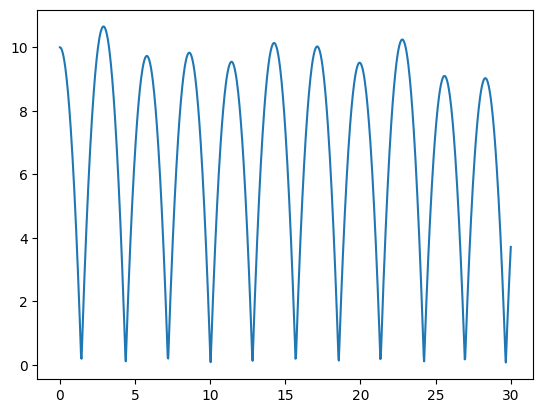

In [12]:
result.abs().plot()

Hmm, that's not right. It's losing energy. We need a smaller time step.

<Axes: >

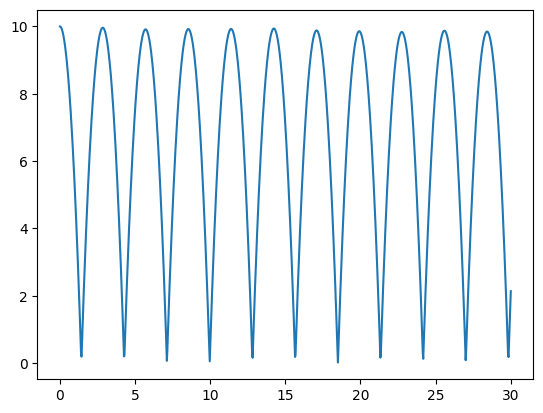

In [13]:
sol = solve_ivp(system, t_span, [x0, v0], args=(9.81,), dense_output=True, max_step=0.01)

# Create evaluation points for plotting
t_eval = np.linspace(0, 30, 1000)
solution_points = sol.sol(t_eval)

# Display some solution points
result = pd.Series(solution_points[0], index=t_eval)
result.abs().plot()


In [14]:
from matplotlib.animation import FuncAnimation

result_abs = result.abs()

# Create figure with two subplots - now side by side instead of stacked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[5, 1])

# Set axis limits for particle animation subplot
y_min = result_abs.min() - 0.5
y_max = result_abs.max() + 0.5
ax1.set_ylim(y_min, y_max)
ax1.set_xlim(0, result_abs.index.max())
ax1.set_title('Position vs Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')

# Plot full position data
ax1.plot(result_abs.index, result_abs, 'b-', label='Particle 1')
ax1.legend()

# Create time indicator line
time_line, = ax1.plot([], [], 'g-', linewidth=1)

# Set up particle animation subplot
ax2.set_ylim(y_min, y_max)
ax2.set_xlim(-1, 1)
ax2.set_title('Particle Bouncing')
ax2.set_xlabel('')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# Create particle objects
particle1, = ax2.plot([], [], 'bo', markersize=5, label='Particle 1')

# Animation initialization function
def init():
    particle1.set_data([], [])
    time_line.set_data([], [])
    return particle1, time_line

# Animation update function
def animate(frame):
    # Update particle position
    y_particle = result_abs.iloc[frame]
    particle1.set_data([0], [y_particle])
    
    # Update time indicator line - now vertical instead of horizontal
    time = result_abs.index[frame]
    time_line.set_data([time, time], [y_min, y_max])
    
    return particle1, time_line

# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(result_abs),
    interval=50,  # 50ms between frames
    blit=True,
    repeat=False  # Prevent repeating after animation ends
)
plt.close(fig)

# Display animation
HTML(anim.to_html5_video())